In [1]:
using_colab = True

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-e16xjkx1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-e16xjkx1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=e0587e1a856ea31ed62402a00ce29b9fb6debecaca0478590348ad75e90bd84e
  Stored in directory: /tmp/pip-ephem-wheel-cache-osmbxgps/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-15 11:06:25--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [3]:
pip install torch torchvision segment-anything shapely scikit-learn matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import random
import matplotlib.pyplot as plt

# **Exemple PIE implémentation sur 1 image**

Voici une première version du PIE, testée sur une seule image.

Actuellement, l’EAC détecte principalement les oreilles du chien ainsi qu’une partie de la gamelle, qui semblent être les concepts les plus importants. Mais, je pense que ce résultat peut être nettement amélioré. Par manque de ressources, j’ai pas pu tester autant de coalitions que dans l’article original (1 000 contre 50 000), ce qui limite la qualité des explications générées.

Pour reproduire la suite du papier, il faut retrouver les résultats de faithfulness, understability et ablation study.
Pour ceci, il faudrait :
- Obtenir de meilleurs résultats explicatifs sur une image individuelle.

- Implémenter un code d’évaluation de l’AUC via les méthodes d’insertion et de suppression (insertion/deletion scheme).

- Évaluer le modèle sur un ensemble plus large d’images provenant d’ImageNet et COCO.

- Mesurer la compréhensibilité des masques générés auprès de 6 annotateurs humains.

- Noter et analyser le temps de traitement pour chaque étape.

**Phase 1 : Concept Discovery**

Etape 1-2 : Charger l'image et la segmenter avec SAM

array([[[252, 248, 237],
        [250, 246, 235],
        [249, 245, 234],
        ...,
        [236, 224, 204],
        [239, 228, 206],
        [238, 227, 206]],

       [[252, 248, 237],
        [250, 246, 235],
        [249, 245, 234],
        ...,
        [236, 224, 204],
        [234, 223, 201],
        [231, 220, 199]],

       [[252, 248, 237],
        [250, 246, 235],
        [249, 245, 234],
        ...,
        [240, 227, 207],
        [239, 226, 205],
        [234, 223, 202]],

       ...,

       [[ 92,  73,  54],
        [125, 103,  80],
        [166, 143, 115],
        ...,
        [ 73,  71,  65],
        [ 68,  67,  62],
        [ 62,  59,  55]],

       [[105,  83,  59],
        [136, 112,  84],
        [177, 151, 120],
        ...,
        [ 74,  72,  66],
        [ 70,  68,  64],
        [ 64,  62,  58]],

       [[135, 110,  82],
        [161, 133, 102],
        [197, 167, 133],
        ...,
        [ 74,  72,  67],
        [ 71,  69,  65],
        [ 67,  65,  61]]], dtype=uint8)
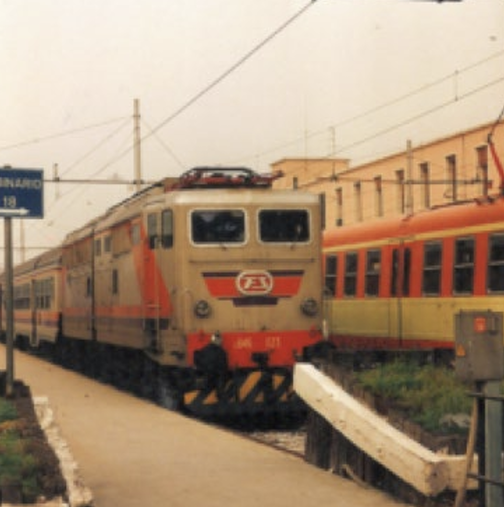

In [2]:
# eac_test_single.py
import torch
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm
import os
import cv2


# === Charger image de test ===
image = cv2.imread('images/train.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image

In [3]:
# === Segmenter avec SAM ===
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [4]:
masks = mask_generator.generate(image)

Vérifier la segmentation de SAM

In [5]:
print(len(masks))
print(masks[0].keys())

100
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [6]:
masks[1]['area']

54935

In [7]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

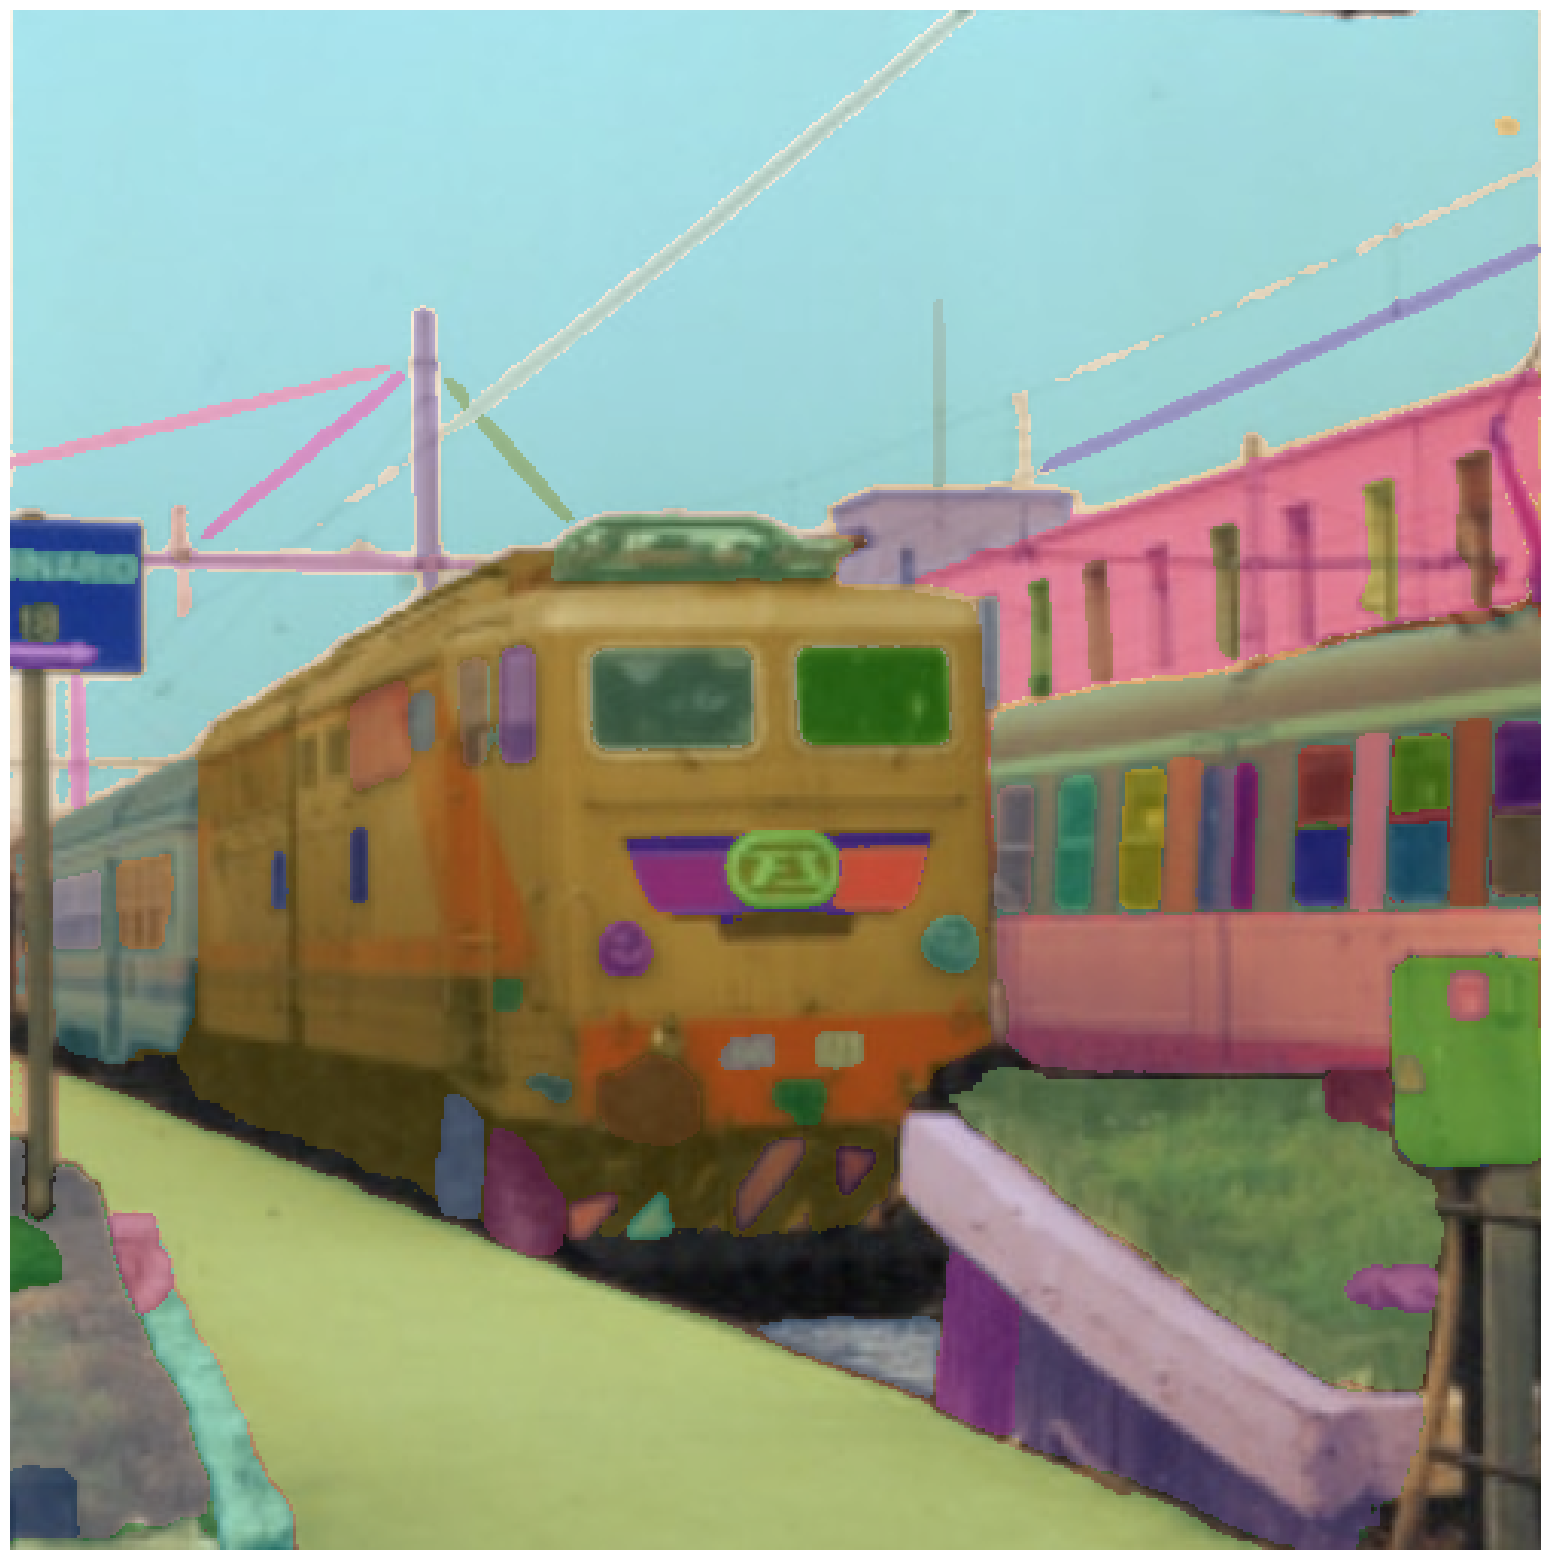

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

**Phase 2 : PIE**

Etape 3 : Charger modèle target Resnet-50

In [9]:
model = models.resnet50(pretrained=True)
model.eval()
model = model.to("cuda")
fc_layer = model.fc
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # sans FC

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 212MB/s]


Etape 3 : Mettre en place le Surrogate modèle

In [10]:
import torch.optim as optim

class SurrogateModel(torch.nn.Module):
    def __init__(self, fc_layer, num_concepts, feature_dim=2048, lr=0.008):
        super().__init__()
        self.h = torch.nn.Sequential(
            torch.nn.Linear(num_concepts, feature_dim)
        )
        self.fc = fc_layer  # partagé avec ResNet

        # Freeze les paramètres
        for param in self.fc.parameters():
          param.requires_grad = False

        self.optimizer = optim.SGD(self.h.parameters(), lr=lr, momentum=0.9)

    def forward(self, b_onehot):
        features = self.h(b_onehot)
        return self.fc(features)

num_concepts = len(masks)
surrogate = SurrogateModel(fc_layer, num_concepts).to("cuda")
optimizer = torch.optim.Adam(surrogate.h.parameters(), lr=0.008)
loss_fn = torch.nn.CrossEntropyLoss()

Etape 5 : Créer le dataset d'entrainement du surrogate model = (image dont  certains concepts masqués, prédiction label du target model avec cette image masquée)

In [14]:
import torchvision.transforms as transforms

# === créer les coalitions d’entraînement ===
def mask_image_from_concepts(concepts, concept_mask, image):
    """
    Masque l'image en gardant uniquement les concepts activés dans concept_mask.
    Le masquage est fait par multiplication, pas par remplacement par zéro direct.

    Args:
        concepts (list of np.array): Liste de masques booléens (H x W) pour chaque concept.
        concept_mask (np.array): Vecteur binaire de sélection des concepts (taille = nb concepts).
        image (np.array): Image RGB originale (H x W x 3), dtype uint8.

    Returns:
        masked_img_tensor (torch.Tensor): Image masquée, normalisée, shape [1, 3, H, W].
    """

    # Initialiser un masque combiné float 2D (H x W) à 0
    mask_combined = np.zeros(image.shape[:2], dtype=float)

    for i, mask in enumerate(concepts):
        if concept_mask[i]:
            # Ajouter la région du concept (mask binaire converti en float)
            mask_combined += mask.astype(float)

    # Clamp pour ne pas dépasser 1 (en cas de chevauchement)
    mask_combined = np.clip(mask_combined, 0, 1)

    # Étendre mask_combined sur les 3 canaux (H x W -> H x W x 3)
    mask_combined_3ch = np.repeat(mask_combined[:, :, np.newaxis], 3, axis=2)

    # Multiplier pixel-wise (float multiplication)
    masked_img = image.astype(float) * mask_combined_3ch

    # Remettre au format uint8
    masked_img = masked_img.astype(np.uint8)

    # Convertir en tensor, permuter (H, W, C) -> (C, H, W) et normaliser
    masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1).float() / 255.
    masked_img_tensor = normalize(masked_img_tensor)
    masked_img_tensor = masked_img_tensor.unsqueeze(0)  # batch dimension

    return masked_img_tensor

normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

In [30]:
samples = []
labels = []
concepts = [mask["segmentation"] for mask in masks]
for _ in range(2500):
    mask_bin = np.random.randint(0, 2, size=(num_concepts,)) # c est un vecteur binaire [0 1 0 1 0 ...] : maskbin[5] = 0 = masque le cinquième concept
    x_masked = mask_image_from_concepts(concepts, mask_bin, image) # image originale masquée

    # get predictions of the target model
    with torch.no_grad():
        out = model(x_masked.to("cuda"))
        target = torch.argmax(out, dim=1).item()
    samples.append(torch.FloatTensor(mask_bin))
    labels.append(target)

samples_tensor = torch.stack(samples).to("cuda")
labels_tensor = torch.LongTensor(labels).to("cuda")

Etape 6 : Train surrogate model with the dataset

In [31]:
# === Entraîner surrogate ===
for epoch in range(200):
    surrogate.train()
    out = surrogate(samples_tensor)
    loss = loss_fn(out, labels_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print("--Epoch :", epoch, "--")
    print("Loss :", loss)

--Epoch : 0 --
Loss : tensor(2.0050, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 1 --
Loss : tensor(1.9050, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 2 --
Loss : tensor(1.7960, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 3 --
Loss : tensor(1.7513, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 4 --
Loss : tensor(1.7067, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 5 --
Loss : tensor(1.5281, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 6 --
Loss : tensor(1.4484, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 7 --
Loss : tensor(1.3693, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 8 --
Loss : tensor(1.2414, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 9 --
Loss : tensor(1.1367, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 10 --
Loss : tensor(1.0387, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 11 --
Loss : tensor(0.9607, device='cuda:0', grad_fn=<NllLossBackward0>)
--Epoch : 12 -

**Phase 3 : Concept based Explanation**

On utilise le PIE à la place du target modèl pour estimer les shapley values

Pour chaque concept calcule sa contribution : Monte Carlo sampling de coalitions

DANS PAPIER K = 50 000. Consomme trop de ressources, j'arrive pas à faire tourner sur GPU.

In [32]:
# === Approximation Shapley (MC sampling) ===
K = 5000
shapley_values = torch.zeros(num_concepts).to("cuda")

for i in range(num_concepts):
    print("Concepts ", i)
    for _ in range(K):
        S = torch.randint(0, 2, (num_concepts,), dtype=torch.float32).to("cuda")
        S[i] = 0
        S_with_ci = S.clone()
        S_with_ci[i] = 1

        pred_with_ci = surrogate(S_with_ci.unsqueeze(0)) # u(S) dans papier
        pred_without_ci = surrogate(S.unsqueeze(0)) # u(S without ci) dans le papier

        diff = pred_with_ci[0].max() - pred_without_ci[0].max()
        shapley_values[i] += diff

        del S_with_ci
        del S

shapley_values /= K

Concepts  0
Concepts  1
Concepts  2
Concepts  3
Concepts  4
Concepts  5
Concepts  6
Concepts  7
Concepts  8
Concepts  9
Concepts  10
Concepts  11
Concepts  12
Concepts  13
Concepts  14
Concepts  15
Concepts  16
Concepts  17
Concepts  18
Concepts  19
Concepts  20
Concepts  21
Concepts  22
Concepts  23
Concepts  24
Concepts  25
Concepts  26
Concepts  27
Concepts  28
Concepts  29
Concepts  30
Concepts  31
Concepts  32
Concepts  33
Concepts  34
Concepts  35
Concepts  36
Concepts  37
Concepts  38
Concepts  39
Concepts  40
Concepts  41
Concepts  42
Concepts  43
Concepts  44
Concepts  45
Concepts  46
Concepts  47
Concepts  48
Concepts  49
Concepts  50
Concepts  51
Concepts  52
Concepts  53
Concepts  54
Concepts  55
Concepts  56
Concepts  57
Concepts  58
Concepts  59
Concepts  60
Concepts  61
Concepts  62
Concepts  63
Concepts  64
Concepts  65
Concepts  66
Concepts  67
Concepts  68
Concepts  69
Concepts  70
Concepts  71
Concepts  72
Concepts  73
Concepts  74
Concepts  75
Concepts  76
Concepts 

In [33]:
shapley_values

tensor([ 0.9475,  4.0812,  4.4330,  0.6511,  0.2503,  0.3774,  1.5700,  0.6948,
         1.2657,  0.5900,  0.4085,  0.3230,  0.8203,  0.2557,  0.6889,  0.5155,
         0.5243,  1.4361,  0.5588,  1.1349,  0.4219,  0.5291,  0.8361,  0.3095,
         0.8393,  0.4151,  0.5140,  0.4861,  0.3061,  0.4368,  0.8795,  0.5048,
         1.1153,  0.4601,  0.5297,  0.2898,  0.6663,  0.1852,  0.9588,  0.4996,
         0.8699,  0.6711,  0.2141,  1.2633,  0.6811,  0.5454,  0.5104,  0.4107,
         1.7264,  0.3776,  0.5886,  0.3429,  0.3438,  0.6614,  0.5814,  0.6705,
         0.3635,  1.3041,  0.0083,  0.5555,  0.1720,  0.5238,  0.6430,  0.6170,
         0.3930,  0.5849,  0.6749,  0.3300,  0.5327,  0.1455,  0.7734,  0.7167,
         0.7418,  0.2099,  0.2948,  0.4758,  0.7315,  0.5637,  0.2931,  0.2326,
         0.5788,  0.4821,  1.5839,  0.1802,  0.7833,  0.5026,  0.4894,  0.6039,
         0.3752,  0.7260,  0.9766,  0.6840,  0.4218, -0.0760,  0.2224,  0.5082,
         0.6561,  0.6680,  0.7712,  0.68

J'ai choisi ensuite les 5 concepts avec la pls grandes valeurs de shapley (5 c'est arbitraire)

In [34]:
k = 8
_, topk_indices = torch.topk(shapley_values, k)
E = topk_indices
print("Top-k concepts contributing the most:", E.tolist())

Top-k concepts contributing the most: [2, 1, 48, 82, 6, 17, 57, 8]


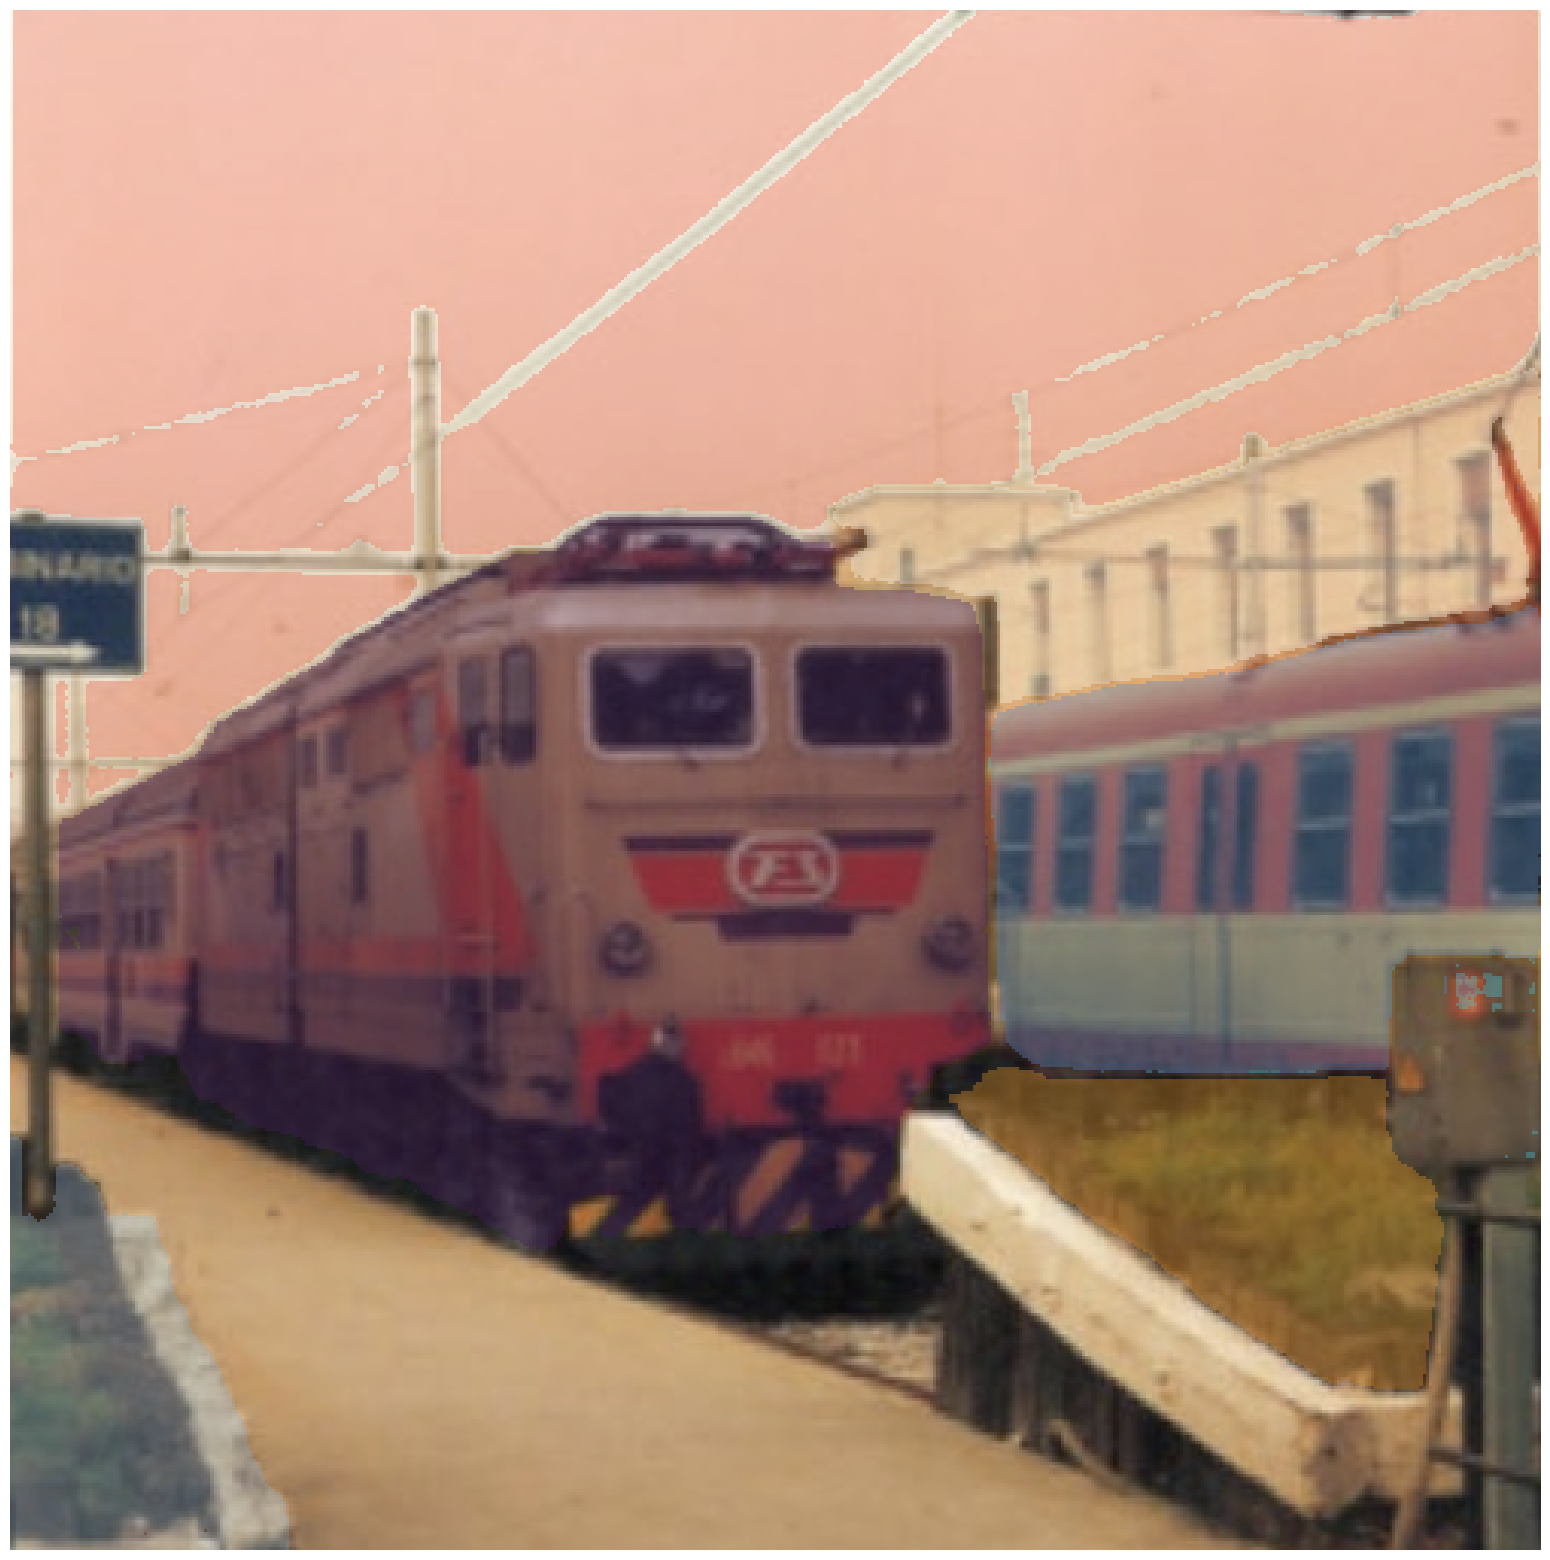

In [35]:
masks_shapley = [mask for i, mask in enumerate(masks) if i in E]
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks_shapley)
plt.axis('off')
plt.show()

**Evaluation metric**

Insertion and Deletion scheme

In [40]:
from sklearn.metrics import auc
import numpy as np

# --- Étape 1 : Ordonner les concepts par importance SHAP ---
shap_np = shapley_values.detach().cpu().numpy()
sorted_idx = np.argsort(-shap_np)  # du + important au -
sorted_masks = [concepts[i] for i in sorted_idx]  # concepts = liste de masques binaires HxW


# --- Étape 2 : Fonction insertion/deletion ---
def apply_concepts(img, masks, model, normalize, mode='insertion', image_class=None):
    """
    img: image originale (numpy RGB)
    masks: liste de masques ordonnés par importance
    model: modèle de prédiction
    normalize: transform PIL/numpy -> normalized torch.Tensor
    mode: 'insertion' ou 'deletion'
    image_class: classe cible (int)
    """
    H, W, C = img.shape
    base = np.zeros_like(img) if mode == 'insertion' else img.copy()
    step_preds = []

    for i in range(len(masks)):
        mask = masks[i][:, :, None]  # shape (H, W, 1)
        if mode == 'insertion':
            base = np.where(mask, img, base)
        elif mode == 'deletion':
            base = np.where(mask, 0, base)

        with torch.no_grad():
            # torch transform
            inp = torch.from_numpy(base).permute(2, 0, 1).float() / 255.  # [3,H,W]
            inp = normalize(inp).unsqueeze(0).to("cuda")  # [1,3,H,W]
            pred = model(inp)
            if image_class is None:
                image_class = pred.argmax().item()
            proba = torch.softmax(pred, dim=1)[0, image_class].item()

        step_preds.append(proba)

    return step_preds

# --- Étape 3 : AUC ---
def compute_auc(step_preds):
    x = np.linspace(0, 1, len(step_preds))
    return auc(x, step_preds)


# --- Étape 4 : Calcule les scores ---
# Choisir la classe prédite initialement
with torch.no_grad():
    inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
    inp = normalize(inp).unsqueeze(0).to("cuda")
    image_class = model(inp).argmax().item()

insertion_scores = apply_concepts(image, sorted_masks, model, normalize, mode='insertion', image_class=image_class)
deletion_scores = apply_concepts(image, sorted_masks, model, normalize, mode='deletion', image_class=image_class)

insertion_auc = compute_auc(insertion_scores)
deletion_auc = compute_auc(deletion_scores)

print(f"Insertion AUC: {insertion_auc:.4f}")
print(f"Deletion AUC: {deletion_auc:.4f}")

Insertion AUC: 0.0328
Deletion AUC: 0.0010
